## Definições iniciais
Esta seção compõe a base para a execução das análises deste notebook. As funções de manipulação de dados foram todas definidas aqui para apenas serem utilizadas na parte de visualização, reduzindo a quantidade de código onde as conclusões são mais importantes.

Como objetivo final, este estudo busca entender o racional de alocação de UBS por um estado. Descoberta a lógica, segue-se para a crítica da mesma, com a possível criação de um modelo capaz de executar com eficiência uma alocação de nova UBS.

In [28]:
import math
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

In [33]:
base_path = "/media/bruno/Arquivos/Desenvolvimento/UBS"
def get_dataset() -> pd.DataFrame:
    # Carrega base bruta
    dataset = pd.read_csv(f"{base_path}/data/dataset.csv")

    # Utiliza aproximação de triângulo retângulo e milha náutica para cálculo das
    # distâncias das unidades até o centro da cidade, uma vez que as distâncias são
    # pequenas (menores que 800 NM) e não é necessário implementar Haversine.
    conversion = 60 * 1.852
    dataset["DISTANCE"] = np.sqrt(
        np.power((dataset["CITY_LAT"] - dataset["UBS_LAT"]) * conversion, 2)
            + np.power((dataset["CITY_LON"] - dataset["UBS_LON"]) * conversion, 2)
    )

    return dataset.query("UF != 'DF'")


def sort_with_category(x: list, y: list) -> None:
    for i in range(0, len(y)):
        for j in range(i + 1, len(y)):
            if y[j] > y[i]:
                y[i], y[j] = y[j], y[i]
                x[i], x[j] = x[j], x[i]


def fill_nan(df: pd.DataFrame, column: str) -> pd.DataFrame:
    total, quantity, values = 0, 0, []
    for i in range(0, len(df)):
        if df[column].values[i] == 0 or df[column].values[i] == np.nan:
            continue

        total = total + df[column].values[i]
        quantity = quantity + 1

    mean = total / quantity if quantity != 0 else 0
    for i in range(0, len(df)):
        if df[column].values[i] == 0 or df[column].values[i] == np.nan:
            values.append(mean)
        else:
            values.append(df[column].values[i])
    
    df[column] = values
    return df


def get_color(key) -> str:
    if key == "black":
        return "#808080"
    elif key == "focus":
        return "#f3e79d"

Uma hipótese inicial era de que a alocação de UBS se dava em função da população e/ou PIB. Assim, SP deveria de apresentar uma quantidade absurdamente maior do que os demais estados, mas isto não é verificado nem na quantidade absoluta (Figura 1) e nem na quantidade de UBS por cidade (Figura 2). Por outro lado, a quantidade de UBS parece ser mais relacionada com a quantidade de cidades (Figura 3).

Essa relação entre quantidade de cidades e quantidade de UBS fica mais visível pelo formato das distribuições, onde o decrescimento ocorre de maneira menos acentuada, quando comparada com as distribuições de PIB e população. Tal observação possui certa lógica, já que o objetivo do governo é alocar UBS nas cidades, estados com mais cidades deveriam de ter mais UBS.

O ponto de destaque fica na possível baixa relação entre tamanho da população e a quantidade de UBS. Utilizando uma simplificação de lógica, seria como se o objetivo fosse ter uma UBS por cidade, não importando a quantidade de pessoas lá.

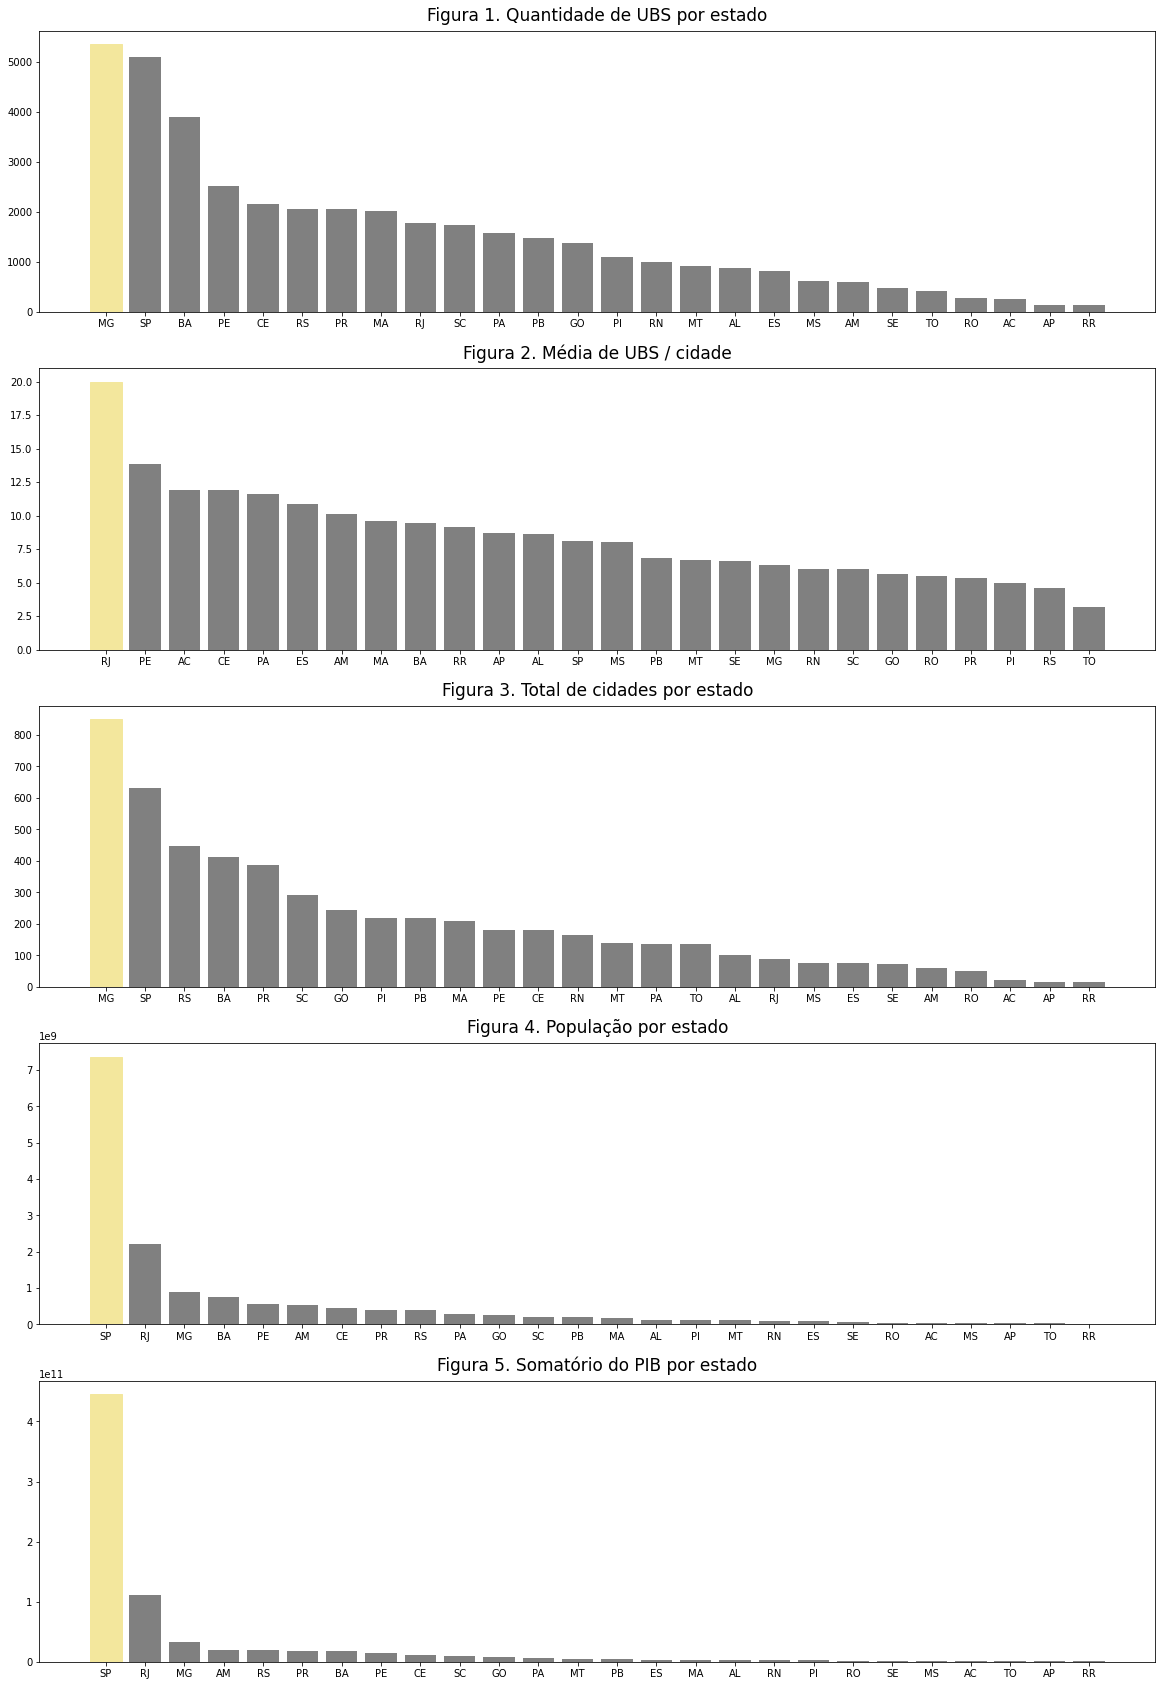

In [31]:
def view_distribution():
    # Carrega dataset e variáveis para plot
    dataset = get_dataset()
    x_ubs, y_ubs = [], []
    x_pop, y_pop = [], []
    x_pib, y_pib = [], []
    x_rel, y_rel = [], []
    x_cit, y_cit = [], []

    # Calcula a quantidade de UBS em cada estado
    serie = dataset["UF"].value_counts()
    for index in serie.index:
        x_ubs.append(index)
        y_ubs.append(serie[index])
    sort_with_category(x_ubs, y_ubs)

    # Calcula a média de UBS / Cidade em cada estado
    for index in serie.index:
        cities = len(dataset.query(f"UF == '{index}'")["CITY"].unique())
        x_rel.append(index)
        y_rel.append(serie[index] / cities if cities != 0 else 0)
    sort_with_category(x_rel, y_rel)

    # Calcula a quantidade de cidades em cada estado
    for index in serie.index:
        cities = len(dataset.query(f"UF == '{index}'")["CITY"].unique())
        x_cit.append(index)
        y_cit.append(cities)
    sort_with_category(x_cit, y_cit)

    # Calcula a quantidade de pessoas em cada estado e o PIB
    dataset = fill_nan(dataset, "PIB_2019")
    dataset = fill_nan(dataset, "POPULATION_2021")
    group = dataset.groupby("UF")[["POPULATION_2021", "PIB_2019"]].agg("sum")

    for index in group["POPULATION_2021"].index:
        x_pop.append(index)
        y_pop.append(group["POPULATION_2021"][index])
    sort_with_category(x_pop, y_pop)

    for index in group["PIB_2019"].index:
        x_pib.append(index)
        y_pib.append(group["PIB_2019"][index])
    sort_with_category(x_pib, y_pib)

    # Faz a exibição dos gráficos para visualização
    data = [
        {"title": "Figura 1. Quantidade de UBS por estado", "categories": x_ubs, "values": y_ubs},
        {"title": "Figura 2. Média de UBS / cidade", "categories": x_rel, "values": y_rel},
        {"title": "Figura 3. Total de cidades por estado", "categories": x_cit, "values": y_cit},
        {"title": "Figura 4. População por estado", "categories": x_pop, "values": y_pop},
        {"title": "Figura 5. Somatório do PIB por estado", "categories": x_pib, "values": y_pib}
    ]

    fig, ax = plt.subplots(len(data), 1, figsize=(20, 30))
    for i in range(0, len(data)):
        category_number = [j for j in range(len(data[i]["categories"]))]
        chart = ax[i].bar(category_number, data[i]["values"], color=get_color("black"))
        ax[i].set_xticks(category_number, labels=data[i]["categories"], fontsize=10)
        ax[i].set_title(data[i]["title"], pad=10, fontdict={"fontsize": 17})
        chart[0].set_color(get_color("focus"))


view_distribution()

Duas abordagens podem ser realizadas para coeficiente de correlação. A primeira visa agrupar por cidade, verificando se existem indícios de relação entre quantidade de UBS, área, população e distância da unidade até o centro da cidade. O resultado desta análise aponta para uma correlação moderada (~0,60) entre população e quantidade de UBS. Ou seja, dentro de uma cidade, possivelmente o número de pessoas exerce certa influência sobre o número de UBS.

A próxima abordagem é utilizando um agrupamento por estado. Esta resulta em um espaço amostral pequeno (26 estados brasileiros), não muito ideal para os cálculos. Todavia, ainda pode ser utilizada como uma forma de "ilustração" e para fornecer uma tradução numérica para a análise visual feita anteriormente. E o resultado corrobora para a fortíssima correlação (~0,9) entre número de cidades e quantidade de UBS. Nesta visão a população também aparece com uma correlação moderada (~0,6).

Como resultado, percebemos que ao avaliar o estado, número de cidades é de extrema importância. Porém, a população também parece exercer certa influência, de modo que não seria prudente ignorar a mesma nas próximas ponderações.

In [48]:
def show_corr():
    # Carrega dataset
    dataset = get_dataset()
    corr = dataset[["POPULATION_2021", "AREA", "PIB_2019", "DISTANCE"]].corr()
    data = []
    for city in dataset["CITY"].unique():
        subset = dataset.query(f"CITY == '{city}'")
        data.append({
            "UBS": len(subset),
            "AREA": np.sum(subset["AREA"].values),
            "DISTANCE": np.mean(subset["DISTANCE"].values),
            "POPULATION": np.sum(subset["POPULATION_2021"].values)
        })
    print(pd.DataFrame(data).corr())

    data = []
    for uf in dataset["UF"].unique():
        subset = dataset.query(f"UF == '{uf}'")
        data.append({
            "UBS": len(subset),
            "CITIES": len(subset["CITY"].unique()),
            "DISTANCE": np.mean(subset["DISTANCE"].values),
            "AREA": np.sum(subset["AREA"].values),
            "POPULATION": np.sum(subset["POPULATION_2021"].values)
        })
    print("\n")
    print(pd.DataFrame(data).corr())


show_corr()

                 UBS      AREA  DISTANCE  POPULATION
UBS         1.000000  0.327166  0.087238    0.648275
AREA        0.327166  1.000000  0.187161    0.162111
DISTANCE    0.087238  0.187161  1.000000    0.022501
POPULATION  0.648275  0.162111  0.022501    1.000000


                 UBS    CITIES  DISTANCE      AREA  POPULATION
UBS         1.000000  0.913130 -0.368818  0.162015    0.628207
CITIES      0.913130  1.000000 -0.417237  0.078375    0.492266
DISTANCE   -0.368818 -0.417237  1.000000  0.205003   -0.149396
AREA        0.162015  0.078375  0.205003  1.000000    0.029974
POPULATION  0.628207  0.492266 -0.149396  0.029974    1.000000


In [30]:
def view_distances():
    # Calcula estatísticas descritivas relacionadas com a distância do centro
    dataset = get_dataset()
    group = dataset.groupby("UF")[
        ["DISTANCE"]
    ].agg(["min", "mean", "median", "max"]).sort_values(("DISTANCE", "max"), ascending=False)
    print(group)


view_distances()

    DISTANCE                                             
         min       mean    median         max      valley
UF                                                       
MS  0.000000  22.585492  1.451449  358.136142  358.136142
SC  0.033428   4.048946  1.571474  276.588372  276.554944
MT  0.085497   6.550510  1.550385  217.730459  217.644961
PA  0.108010   9.732639  1.632246  143.416302  143.308292
MG  0.000000   3.750118  1.203210  140.273885  140.273885
RR  0.000000  16.849317  1.950227  139.750796  139.750796
RJ  0.000000   7.757559  2.568544  137.177952  137.177952
AM  0.090069   8.332859  3.144355  135.923779  135.833710
CE  0.030895   6.336035  1.414327  134.397694  134.366799
BA  0.033796   5.980804  1.201947  134.134517  134.100721
MA  0.028482   6.759202  1.221979  133.590524  133.562042
AP  0.187954  11.442283  1.338062  132.453756  132.265802
RO  0.018988   6.842966  1.391054  125.304084  125.285095
RS  0.000000   4.404892  1.462647  123.433348  123.433348
GO  0.000000  